# Cell Based Analysis

In [35]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os  
import shutil
import random
from sklearn.metrics import mean_squared_error
import scipy.stats as st 
import tqdm
import pickle
import re
from io import StringIO
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import tarfile
import scipy as sc


plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 600
plt.style.use('ggplot')
random.seed(100)

In [36]:
wd = os.getcwd()
wd

path = os.path.join(os.path.join(wd, "data"), "cell")
path

'/Users/jakegwinn/Documents/argonne_all/argonne/data/cell'

## Untar Files

In [37]:
# for d in os.listdir(path):
#     folder = os.path.join(path, d)
#     if os.path.isdir(folder):
       
        
#         for f in tqdm.tqdm(os.listdir(folder), desc=f"{folder}"):
#             sub_dir = os.path.join(folder, f)
            
#             if os.path.isdir(sub_dir):
                
                
#                 for t in os.listdir(sub_dir):

#                     file = os.path.join(sub_dir, t)
#                     if not os.path.isdir(file) and tarfile.is_tarfile(file):

#                         tf = tarfile.open(file)
#                         tf.extractall(sub_dir)
#                         tf.close()

## Functions

In [38]:
def get_data_ALL(path, wanted_jobs):
    """Get all drug data into one dictionary from all specified jobs

    Args:
        path (string): path to list of tsv's
        wanted_jobs (list): list of jobs to look through

    Returns:
        dictonary: dictionary indexed by drug name
    """
    # wanted_jobs = os.listdir(path)
    cell_perf = {}

    for job in os.listdir(path):
        j_path = os.path.join(path, job)
        
        if job in wanted_jobs:
        
            for fold in os.listdir(j_path):
                
                fold_path = os.path.join(j_path, fold)
                
                if os.path.isdir(fold_path):
                
                    inner_most = os.path.join(fold_path, job) 
                    # print(f"###{fold}####")
                    for num in os.listdir(inner_most):
                        num_path = os.path.join(inner_most, num)
                        tsv_file = os.path.join(num_path, "predicted.tsv")
                        log_file = os.path.join(num_path, "python.log")
                # if job in wanted_jobs:    
                #     for model in tqdm.tqdm(os.listdir(curr), desc=f"{job}"):
                #         inner = os.path.join(curr, model)
                        
                #         for subdir, dirs, files in os.walk(inner):
                #             for file in files:
                                # f = os.path.join(subdir, file)
                        df = pd.read_csv(tsv_file, sep="\t")
                        # print(df.columns)
                        
                        cell = df["Sample"][0]
                        # print(drug)
                        if cell not in cell_perf:
                            cell_perf[cell] = []
                            cell_perf[cell].append(df)
                        else:
                            cell_perf[cell].append(df)
                            

    cell_dict = {}
    for key, value in tqdm.tqdm(cell_perf.items()):
        cell_dict[key] = pd.concat(value)
        
        
    return cell_dict

In [39]:
def get_all_drug_dfs(drg, path, wanted_jobs):
    """gets drug dfs and locations of given drug

    Args:
        drg (string): specific drug wanted
        path (string): path to list of TSV's
        wanted_jobs (list): list of jobs to search through

    Returns:
        two lists: list of dfs and list of drug locations
    """
    
    cell_loc = []
    
    # Iterate over every job in the directory 
    for job in os.listdir(path):
        j_path = os.path.join(path, job)
        
        if job in wanted_jobs:
        
            for fold in os.listdir(j_path):
                fold_path = os.path.join(j_path, fold)
                
                if os.path.isdir(fold_path):
                
                    inner_most = os.path.join(fold_path, job) 
                    # print(f"###{fold}####")
                    for num in os.listdir(inner_most):
                        num_path = os.path.join(inner_most, num)
                        tsv_file = os.path.join(num_path, "predicted.tsv")
                        log_file = os.path.join(num_path, "python.log")
        
        
        # for job in os.listdir(path):
        #     curr = os.path.join(path, job)
            
        #     # Check if current job is in the wanted_jobs list 
        #     if job in wanted_jobs:
        #         print(f"----------{job}----------")
        #         samples_rmse_curr = {}
                
        #         # Iterates over every model in the job
        #         for model in tqdm.tqdm(os.listdir(curr)):
        #             inner = os.path.join(curr, model)
                    
        #             # Iterates over every file within the model 
        #             for subdir, dirs, files in os.walk(inner):
        #                 for file in files:
                            
                            # Creates dataframe
                        # f = os.path.join(subdir, file)
                        df = pd.read_csv(tsv_file, sep="\t")
                        
                        # Gets drug
                        cell = df["Sample"][0]
                        # print(drug)
                        fold_num = fold
                        number = num
                        # Checks to see if drug is the same as wanted drug
                        if drg == cell:
                            cell_loc.append((job, fold_num, number))

    dfs = []
    locs = []
    
    # Iterates over all the found locations of the drg TSVs
    for j,folder, number in cell_loc:
        
        file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(path, j), folder), j), number), "predicted.tsv")

        # Make a dataframe and include a new column with what job it is from
        df = pd.read_csv(file, sep="\t")
        df["Job"] = j
        
        locs.append((j,folder))
        dfs.append(df)

    return dfs, locs

In [40]:
def make_distrib_plot(cell, c_dict):
    
    # Get dataframe for specified drug
    drug_df = c_dict[cell]
    
    # Plot Distribution 
    fig, ax1 = plt.subplots()
    
    drug_df["AUCError"].plot.kde(ax=ax1, 
                            grid = True, )
    drug_df["AUCError"].plot.hist(ax=ax1,
                            density = True, 
                            bins=30, 
                            rwidth = 0.9)

    ax1.set_title(f"Distribution of AUC Errors of {cell}\nAll Specified Jobs")
    ax1.set_ylabel("")
    ax1.set_xlabel("AUC Error")

In [41]:
def make_multiplot(cell, path, wanted_jobs):
    
    cell_dfs, cell_jobs = get_all_drug_dfs(drg=cell, path=path, wanted_jobs=wanted_jobs)
    
    # print(drug_dfs)
    
    # Get grid layout
    N = len(cell_dfs)
    x=np.floor(np.sqrt(N))
    y=np.ceil(N/x)
    
    print(f"TOTAL: {N}-----({x, y})")
    
    # Make Subplots
    fig, ax1 = plt.subplots(int(x), int(y), squeeze=False)
    fig.subplots_adjust(hspace=0.4, wspace = 0.45)
    fig.suptitle(f"Distribution of {cell} over all Individual Jobs")
    
    k = 0
    j = 0

    # Iterate over all subplots and plot each distribution for every specified job
    for i, d in enumerate(cell_dfs):
        # print(f"####### {(k,j)} #######")
        # print(d["AUCError"])

        k = int(k)
        j = int(j)
        d["AUCError"].plot.kde(ax=ax1[k][j] )
        d["AUCError"].plot.hist(ax=ax1[k][j],density = False, bins=30, rwidth = 0.9, xlim = (-1, 1))

        ax1[k][j].set_title(f"{cell_jobs[i][0]}", size = 7)
        ax1[k][j].set_ylabel("Frequency",size = 4 )
        ax1[k][j].set_xlabel("AUC Error", size = 4)
        
        k += 1
        k = k % x
        if k == 0:
            j += 1
        j = j % y

In [93]:
def norm_hist(data):
    mu, std = st.norm.fit(data)
    # Plot the histogram.
    plt.hist(data, bins=30, density=True, alpha=0.6, color='b')
    
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = st.norm.pdf(x, mu, std)
    
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
    plt.title(title)
    
    plt.show()

## EDA

### Epoch Comparisons

In [42]:
key_list = ["Job", "Folder", "Num", "drug", "epochs_wanted", "actual_epochs"]
data = {key: [] for key in key_list}

for j in os.listdir(path):
    # print(f"-------------{j}-------------")
    j_path = os.path.join(path, j)
    for fold in os.listdir(j_path):
        fold_path = os.path.join(j_path, fold)
        
        if os.path.isdir(fold_path):
        
            inner_most = os.path.join(fold_path, j) 
            # print(f"###{fold}####")
            for num in os.listdir(inner_most):
                num_path = os.path.join(inner_most, num)
                tsv_file = os.path.join(num_path, "predicted.tsv")
                log_file = os.path.join(num_path, "python.log")
                
                if os.path.exists(tsv_file):
                    df = pd.read_csv(tsv_file, sep="\t")
                    
                    drug = df["Drug1"][0]
                    
                    data["Job"].append(j)
                    data["Folder"].append(fold)
                    data["drug"].append(drug)
                    data["Num"].append(num)
                    prev_epoch_hist_length = len(data["actual_epochs"])
                    log_data = open(log_file, 'r')
                    # data["path"].append(tsv_file)
                    for line in log_data:

                        # Get specified epochs
                        matches_wanted = re.findall("'epochs': \d+", line)
                        
                        # get how many epochs it actually ran for
                        matches_history = re.findall("history_length: \d+", line)

                        if matches_wanted:
                            data["epochs_wanted"].append(matches_wanted[0][-2:]) 
                            # print(matches_wanted[0])
                        # else:
                        #     print("fjdashfkjsahdfhdajkshfkashfjsakhfdkajs")

                        if matches_history:
                            data["actual_epochs"].append(matches_history[0][-2:])
                            # print(matches_history[0])
                            
                        # else:
                        #     print("fjdashfkjsahdfhdajkshfkashfjsakhfdkajs")
                    # if len(data["actual_epochs"]) == prev_epoch_hist_length:
                    #     print(f"{j}: {num}")
                    #     print(log_file)
                    #     print("fdjhfajkhfjbhbhjgbhjghjgjgjhgjhgjhguhuivibkdhajahk")
                else:
                    print(f"{j}/{fold}/{j}/{num}")
                    
                # prev_epoch_hist_length = len(data["actual_epochs"])
    

In [43]:
df = pd.DataFrame(data)
df[["epochs_wanted", "actual_epochs"]] = df[["epochs_wanted", "actual_epochs"]].apply(pd.to_numeric)

In [44]:
df = (df.assign(
        epoch_diff =df["epochs_wanted"] - df["actual_epochs"]
    )
)
# print(len(df.index))
print(df.sort_values(["epochs_wanted", "actual_epochs"], ascending=[False, True]).to_string())

                   Job         Folder  Num       drug  epochs_wanted  actual_epochs  epoch_diff
2564  9013674.amn-0001  x1921c5s5b0n0  148    Drug_10             70             27          43
3253  9013229.amn-0001  x1921c7s2b0n0  259  Drug_1003             70             27          43
5634  9013643.amn-0001  x1921c7s7b0n0  320  Drug_1001             70             27          43
5640  9013643.amn-0001  x1922c0s1b0n0  338    Drug_10             70             27          43
243   9013902.amn-0001  x1922c4s1b0n0  659  Drug_1003             70             28          42
904   9013758.amn-0001  x1922c4s2b0n0  715  Drug_1001             70             28          42
1317  9013758.amn-0001  x1922c1s6b0n0  538  Drug_1003             70             28          42
1689  9013190.amn-0001  x1922c4s0b0n0  600    Drug_10             70             28          42
2782  9013674.amn-0001  x1921c6s2b0n0  176    Drug_10             70             28          42
3531  9013229.amn-0001  x1921c6s2b0n0  1

### Checking all drugs for standouts

In [45]:
cell_dict = get_data_ALL(path=path, wanted_jobs=os.listdir(path))

100%|██████████| 780/780 [00:00<00:00, 1798.15it/s]


In [58]:
key_list = ["Drug", 
            "RMSE", 
            "var", 
            # "cv", 
            "mean",
            "n"]
drugs_rmse = {key: [] for key in key_list}


for key, value in cell_dict.items(): 
    drugs_rmse["Drug"].append(key)
    curr_rmse = mean_squared_error(value["AUC"], value["PredictedAUC"], squared=False)
    curr_var = np.var(value["AUCError"])
    curr_mean = np.mean(value["AUCError"])
    # curr_cv =  (np.std(value["AUCError"]) / np.mean(value["AUCError"])) * 100
    # drugs_rmse["cv"].append(curr_cv)
    drugs_rmse["mean"].append(curr_mean)
    drugs_rmse["RMSE"].append(curr_rmse)
    drugs_rmse["var"].append(curr_var)
    drugs_rmse["n"].append(len(value))

In [96]:
all_drugs_df_n = pd.DataFrame(drugs_rmse).sort_values(["n"], ascending=False)
all_drugs_df_rmse = pd.DataFrame(drugs_rmse).sort_values(["RMSE"], ascending=False)
all_drugs_df_var = pd.DataFrame(drugs_rmse).sort_values(["var"], ascending=False)
# all_drugs_df_cv = pd.DataFrame(drugs_rmse).sort_values(["cv"], ascending=False)/
bad_perf_drugs = all_drugs_df_rmse["Drug"][:3]
all_drugs_df_rmse.head(50)

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_60655/2296779473.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  bad_perf_drugs = all_drugs_df_rmse["Drug"][:3]


,Drug,RMSE,var,mean,n
356,ACH-000068,0.218930,0.025257,-0.150578,3224
179,ACH-000705,0.192770,0.020074,0.130715,568
587,ACH-000923,0.183998,0.022931,0.104522,600
250,ACH-000660,0.181464,0.018141,0.121606,4904
408,ACH-000285,0.174825,0.021111,-0.097226,2344
254,ACH-000269,0.165337,0.026085,0.035367,5728
266,ACH-000889,0.156165,0.018874,-0.074253,3168
725,ACH-000258,0.153226,0.017369,0.078164,8848
529,ACH-000041,0.152717,0.011825,0.107228,64
231,ACH-000707,0.148969,0.016047,-0.078390,5824


Text(0.5, 1.0, 'Distribution of Sample AUCError RMSE')

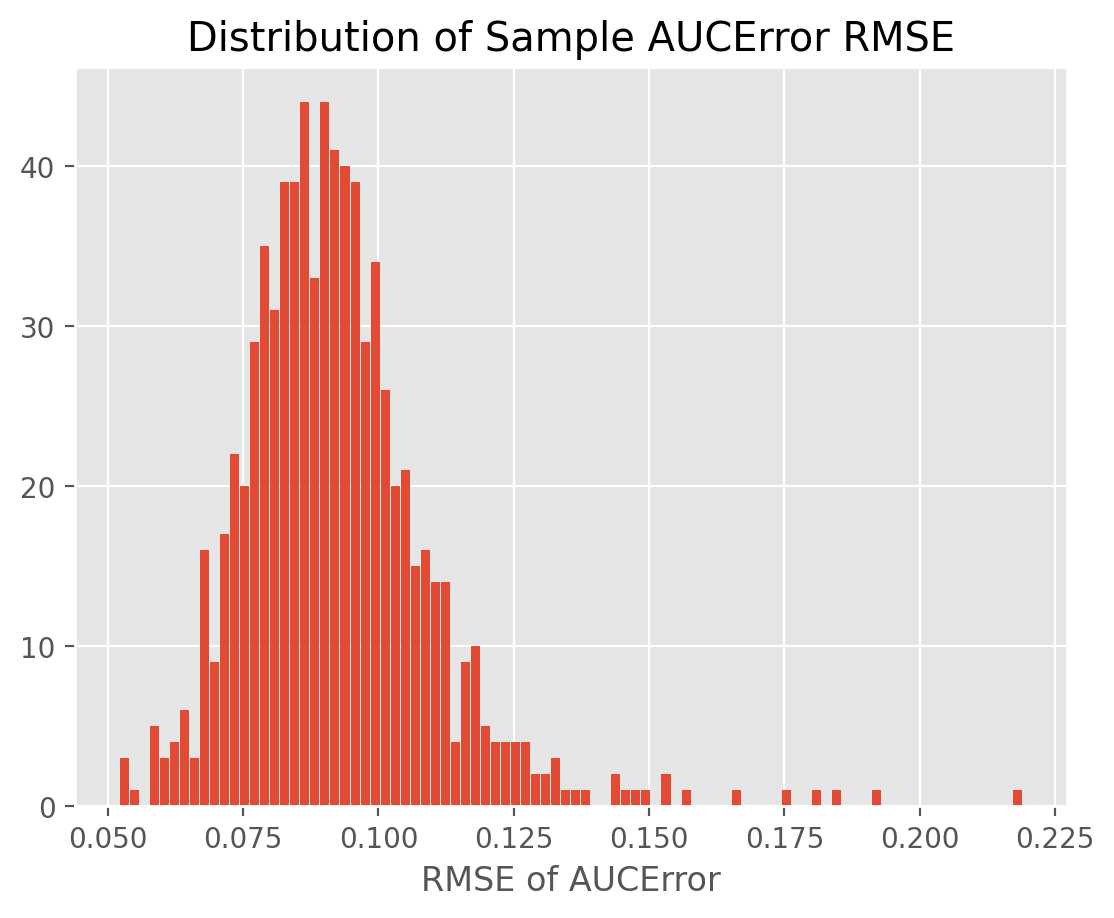

In [90]:
fig, ax1 = plt.subplots()
ax1.hist(x= all_drugs_df_rmse["RMSE"], 
         density = False, 
         bins=90, 
         rwidth = 0.9)
ax1.set_xlabel(f"RMSE of AUCError")
ax1.set_title("Distribution of Sample AUCError RMSE")
# ax1.set_xlim(0, 0.5)

Text(0.5, 1.0, 'Distribution of Sample AUCError Variation')

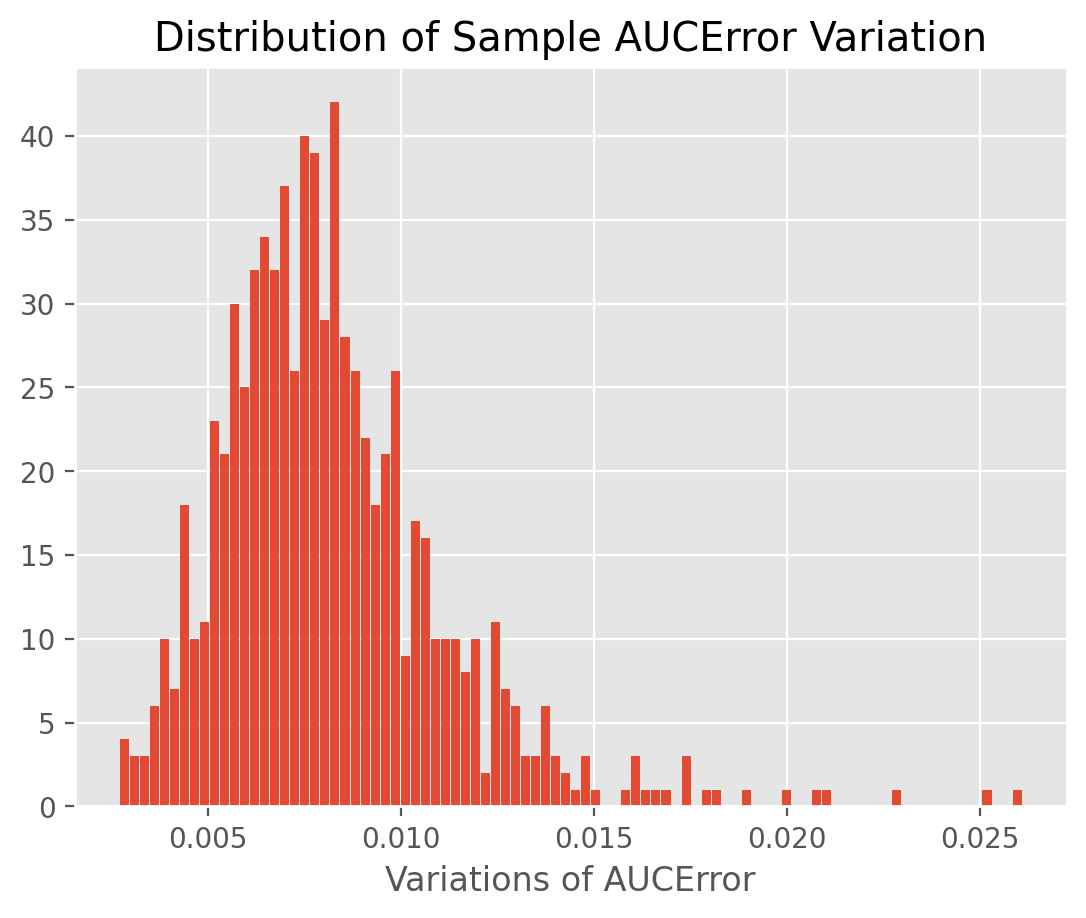

In [85]:
fig, ax1 = plt.subplots()
ax1.hist(x= all_drugs_df_rmse["var"], 
         density = False, 
         bins=90, 
         rwidth = 0.9)
ax1.set_xlabel(f"Variations of AUCError")
ax1.set_title("Distribution of Sample AUCError Variation")

Text(0.5, 1.0, 'Distribution of Sample AUCError Mean')

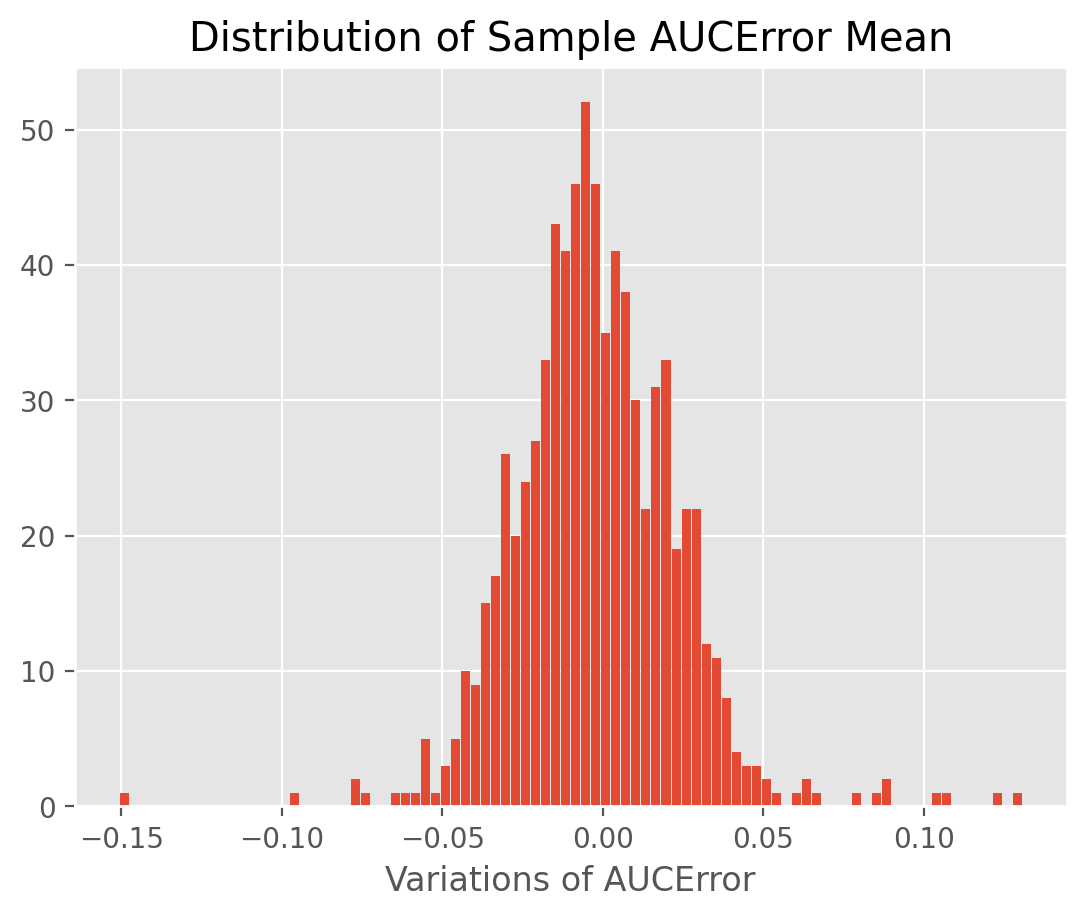

In [86]:
fig, ax1 = plt.subplots()
ax1.hist(x= all_drugs_df_rmse["mean"], 
         density = False, 
         bins=90, 
         rwidth = 0.9)
ax1.set_xlabel(f"Means of AUCError")
ax1.set_title("Distribution of Sample AUCError Mean")

### Worst perfoming drugs per job

In [52]:
drugs_perf = {}

jobs = []

rmse_jobs = []
worst_cells = []
rmse_jobs = []
all_locations = []

for job in os.listdir(path):
    j_path = os.path.join(path, job)
    
    rmses_curr = {}
    
    jobs.append(job)
    
    if job in os.listdir(path):
    
        for fold in os.listdir(j_path):
            
            fold_path = os.path.join(j_path, fold)
            
            if os.path.isdir(fold_path):
            
                inner_most = os.path.join(fold_path, job) 
                # print(f"###{fold}####")
                for num in os.listdir(inner_most):
                    num_path = os.path.join(inner_most, num)
                    tsv_file = os.path.join(num_path, "predicted.tsv")
                    df = pd.read_csv(tsv_file, sep="\t")
                    
                    # Getting folder locatio and which drug it is 
                    fold_num = num
                    cell = df["Sample"][0]
                    
                    rmse = mean_squared_error(df["AUC"], df["PredictedAUC"], squared=False)
                    
                    # print(num, drug)
                    
                    key = (cell, fold_num)
                    rmses_curr[(key)] = rmse
                    # print(rmses_curr)
        cell_drug = max(rmses_curr, key = rmses_curr.get)      
        worst_drug_rmse = rmses_curr[cell_drug]
        print(cell_drug, worst_drug_rmse)
        
        worst_cells.append(cell_drug[0])
        rmse_jobs.append(worst_drug_rmse)
        all_locations.append(cell_drug[1])
        
bad_drugs = pd.DataFrame({"Job":jobs, "Folder":all_locations, "worst_drug":worst_cells, "RMSE":rmse_jobs})
bad_drugs.sort_values("RMSE", ascending=False)

# Getting the frequency of each drug in the worst drug array
cells, counts = np.unique(worst_cells, return_counts=True)

('ACH-000068', '685') 0.2191722189020806
('ACH-000068', '685') 0.21513904927067937
('ACH-000068', '685') 0.2248021136968704
('ACH-000068', '685') 0.21243863478281697
('ACH-000068', '685') 0.21822923124543878
('ACH-000068', '685') 0.21426200180009664
('ACH-000068', '685') 0.2279872281586711
('ACH-000068', '685') 0.21896113266483166


/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_60655/3229604280.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cells, rotation = 45)


Text(0.5, 0.98, 'Worst Performing Drugs Across All Jobs\n(Worst Cell for Each Job)')

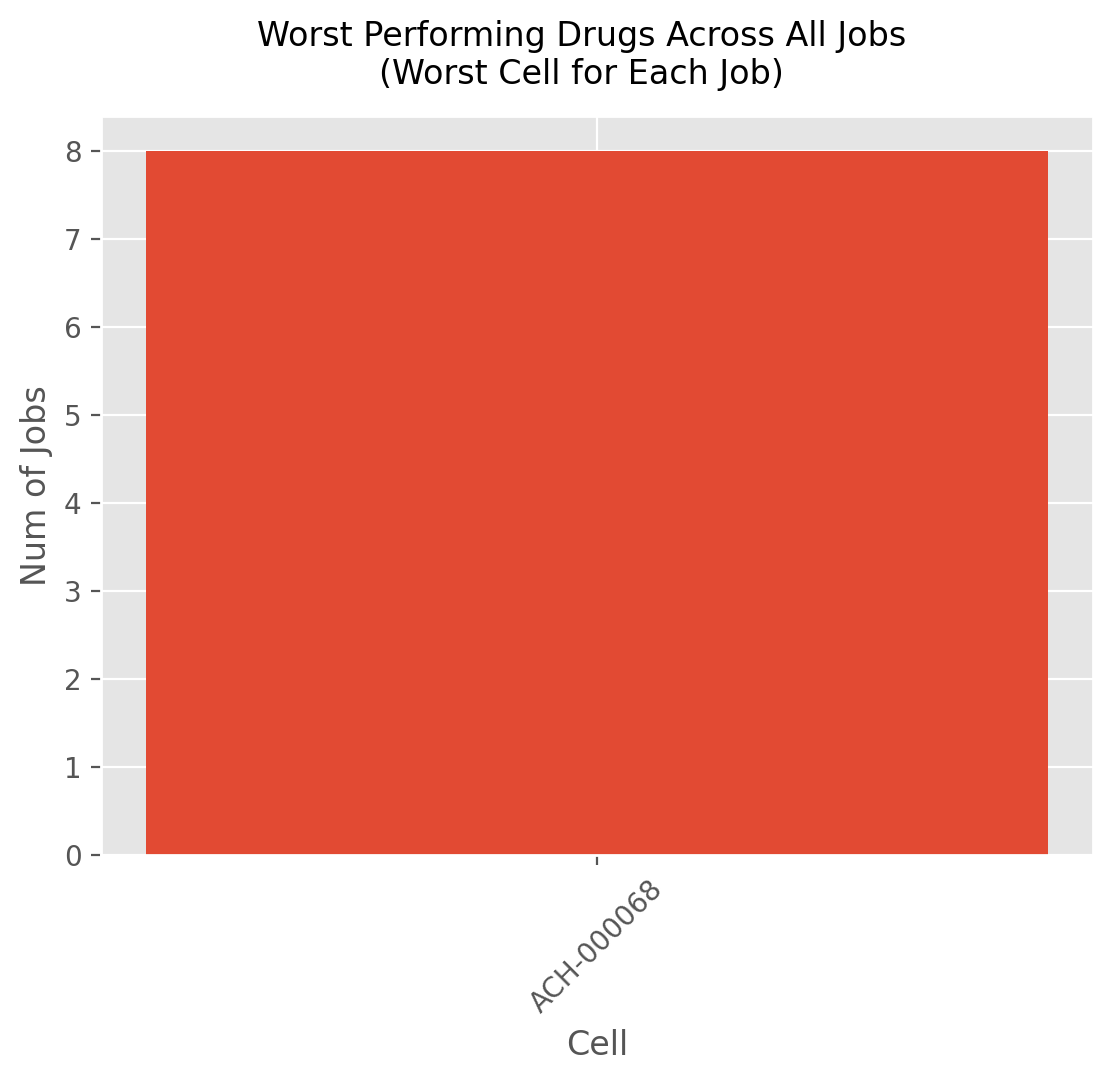

In [53]:
fig, ax = plt.subplots()

ax.bar(cells, counts)

ax.set_xticklabels(cells, rotation = 45)
ax.set_ylabel("Num of Jobs")
ax.set_xlabel("Cell")
fig.suptitle("Worst Performing Drugs Across All Jobs\n(Worst Cell for Each Job)")

## ACH-000068

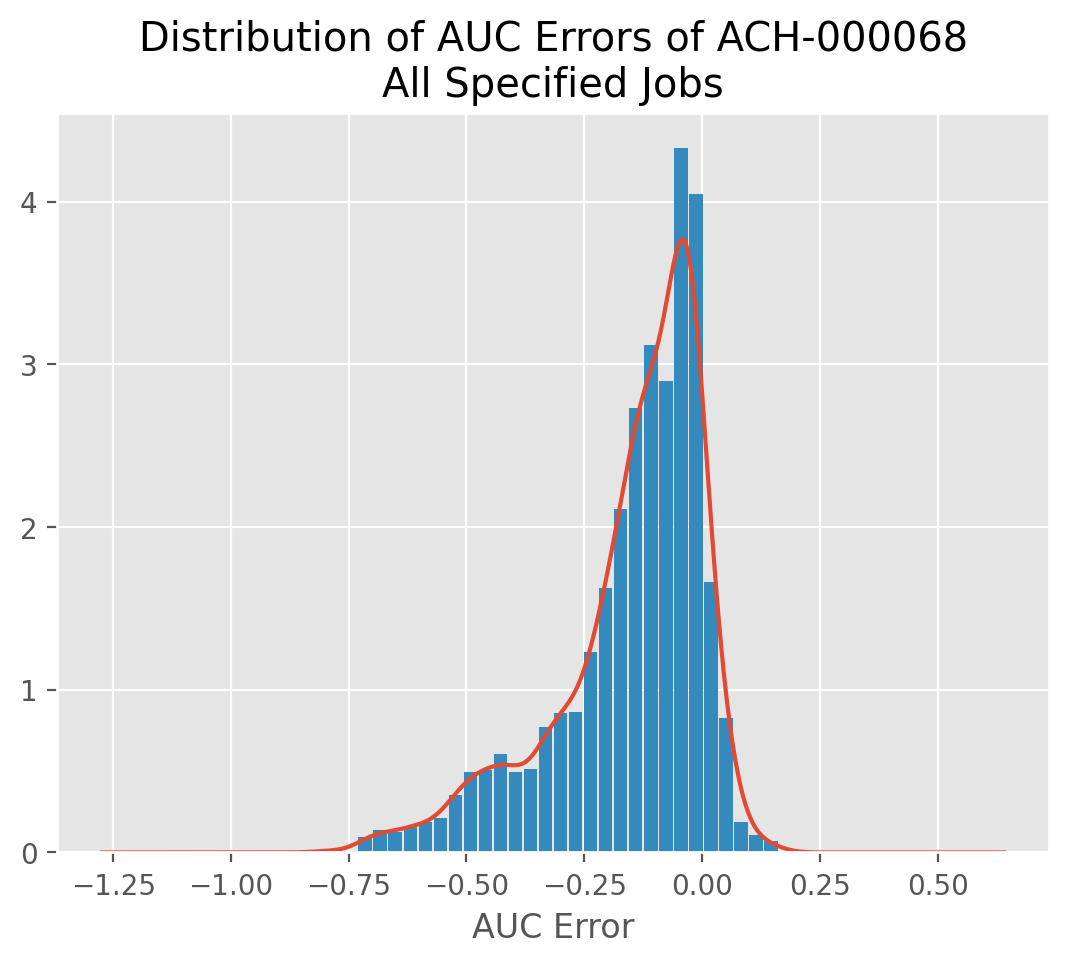

In [54]:
make_distrib_plot("ACH-000068", cell_dict)

TOTAL: 8-----((2.0, 4.0))


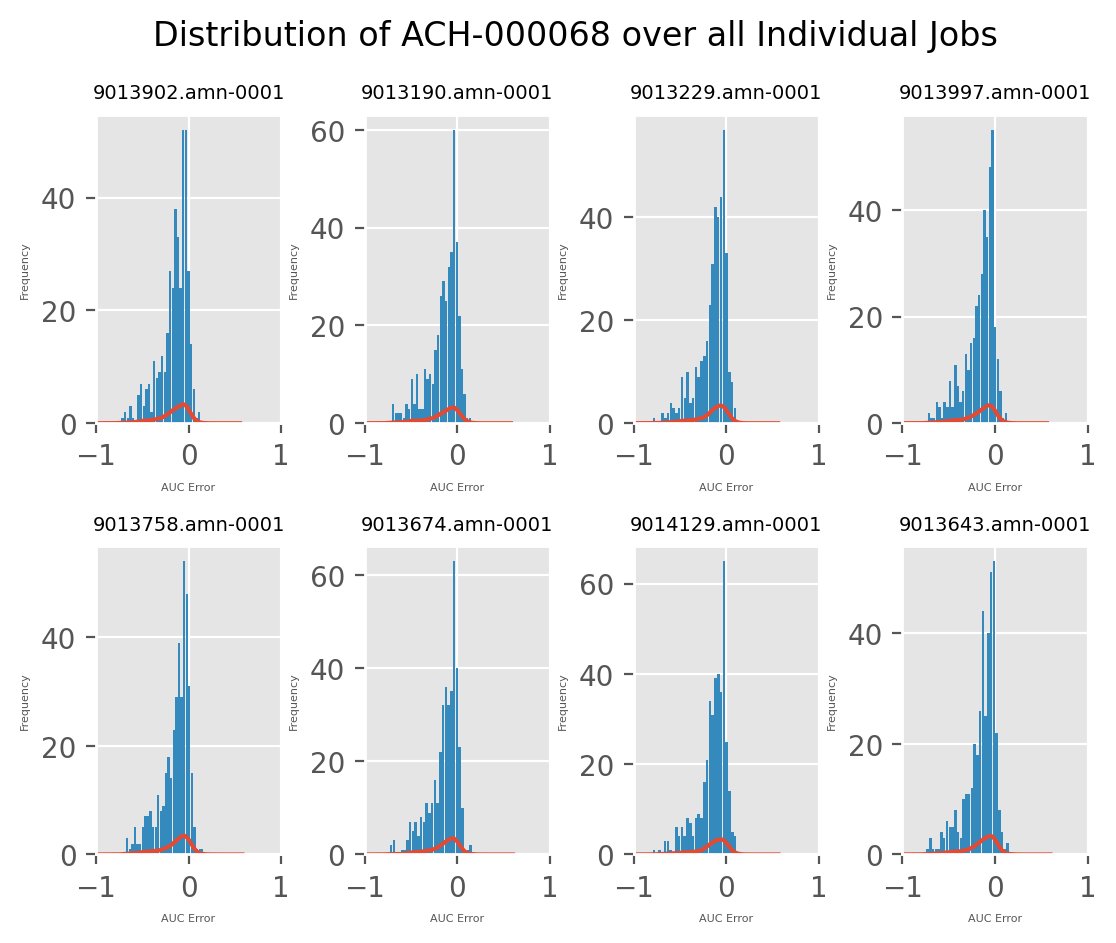

In [55]:
make_multiplot(cell="ACH-000068", path=path, wanted_jobs=os.listdir(path))

In [56]:
dfs_all = []

for v in cell_dict.values():
    dfs_all.append(v)
    
big_df = pd.concat(dfs_all)
big_df

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.9436,ACH-000271,Drug_10,0.9525,0.008882
1,1.0000,ACH-000271,Drug_1003,0.9674,-0.032600
2,0.7438,ACH-000271,Drug_1005,0.8182,0.074410
3,0.7830,ACH-000271,Drug_1005,0.8467,0.063700
4,0.9197,ACH-000271,Drug_1005,0.8369,-0.082800
...,...,...,...,...,...
963,0.9736,ACH-000835,Drug_986,0.9643,-0.009334
964,0.9909,ACH-000835,Drug_987,0.9775,-0.013450
965,0.3731,ACH-000835,Drug_988,0.3817,0.008605
966,0.4614,ACH-000835,Drug_988,0.3498,-0.111600


In [57]:
aucdf = (big_df
    .groupby("Sample")
    .agg({
        "AUCError":"mean"
    })
    .reset_index()
    .sort_values("AUCError", key=np.abs, ascending=False)
    
)

aucdf

,Sample,AUCError
44,ACH-000068,-0.150578
528,ACH-000705,0.130715
492,ACH-000660,0.121606
26,ACH-000041,0.107228
706,ACH-000923,0.104522
...,...,...
448,ACH-000605,0.000256
468,ACH-000630,-0.000255
640,ACH-000837,0.000221
19,ACH-000027,0.000089


(-0.2, 0.2)

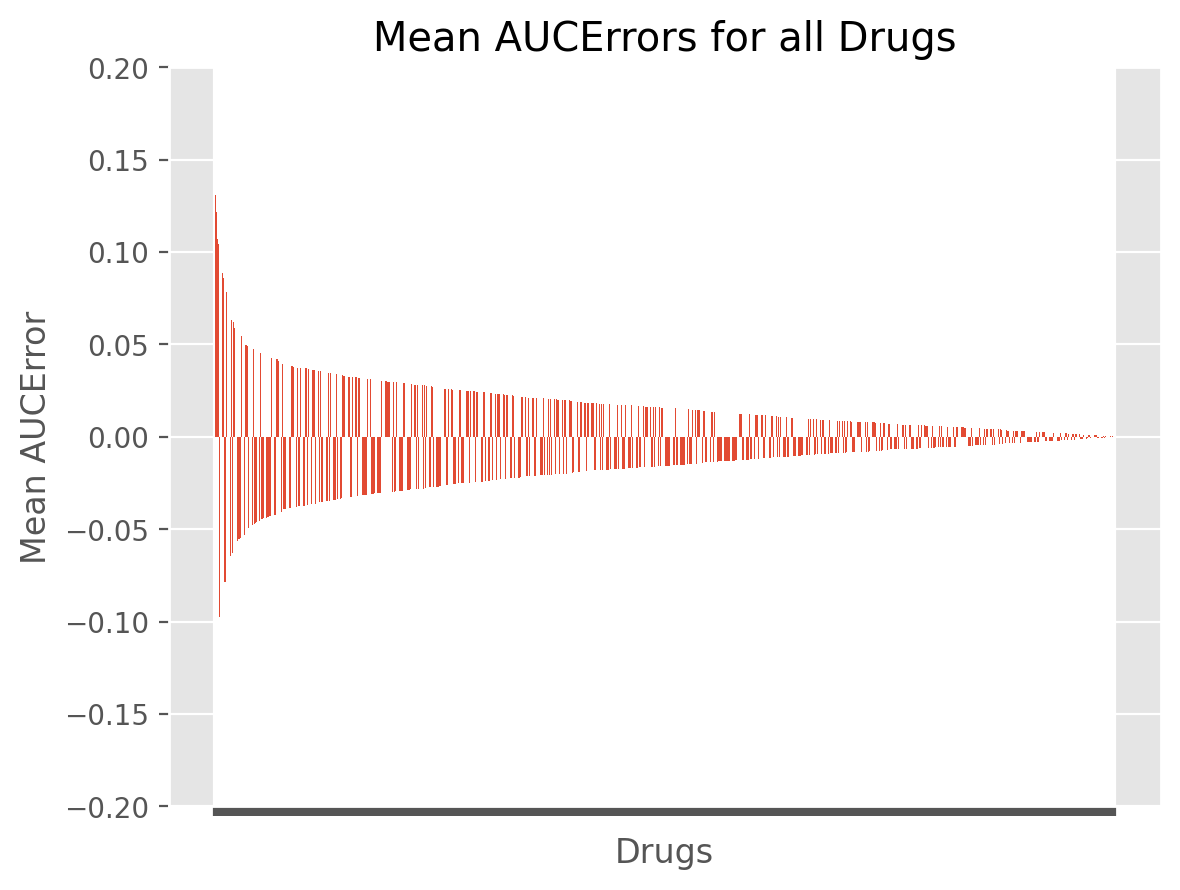

In [68]:
fig, ax = plt.subplots()

ax.bar(x = pd.Categorical(aucdf["Sample"]), height=aucdf["AUCError"], width=0.7)
ax.set_xticklabels([])

ax.set_ylabel("Mean AUCError")
ax.set_xlabel("Drugs")
ax.set_title("Mean AUCErrors for all Drugs")
ax.set_ylim(-0.2, 0.2)

In [73]:
csv = pairwise_tukeyhsd(big_df["AUCError"], big_df["Sample"], alpha = 0.05).summary().as_csv()
turkey_df = pd.read_csv(StringIO(csv), skiprows = 1)
turkey_df
# turkey_df["  group1 "] = turkey_df["  group1 "].str.strip()
# turkey_df["  group2 "] = turkey_df["  group2 "].str.strip()
turkey_df.columns = turkey_df.columns.str.replace(' ', '')

In [92]:
# print(turkey_df[turkey_df["group1"] == "ACH-000068"].to_string())
print(turkey_df[turkey_df["group2"] == "ACH-000068"].to_string())

           group1      group2  meandiff  p-adj   lower   upper  reject
43     ACH-000001  ACH-000068   -0.1179    0.0 -0.1293 -0.1066  True  
821    ACH-000002  ACH-000068   -0.1128    0.0 -0.1224 -0.1031  True  
1598   ACH-000004  ACH-000068   -0.1425    0.0 -0.1525 -0.1325  True  
2374   ACH-000005  ACH-000068   -0.1408    0.0 -0.1522 -0.1295  True  
3149   ACH-000006  ACH-000068   -0.1649    0.0 -0.1748 -0.1550  True  
3923   ACH-000007  ACH-000068   -0.1664    0.0 -0.1759 -0.1568  True  
4696   ACH-000008  ACH-000068   -0.1577    0.0 -0.1673 -0.1481  True  
5468   ACH-000009  ACH-000068   -0.1483    0.0 -0.1579 -0.1388  True  
6239   ACH-000011  ACH-000068   -0.1787    0.0 -0.1905 -0.1669  True  
7009   ACH-000012  ACH-000068   -0.1577    0.0 -0.1672 -0.1482  True  
7778   ACH-000013  ACH-000068   -0.1704    0.0 -0.1816 -0.1592  True  
8546   ACH-000014  ACH-000068   -0.1565    0.0 -0.1677 -0.1454  True  
9313   ACH-000017  ACH-000068   -0.1438    0.0 -0.1555 -0.1321  True  
10079 

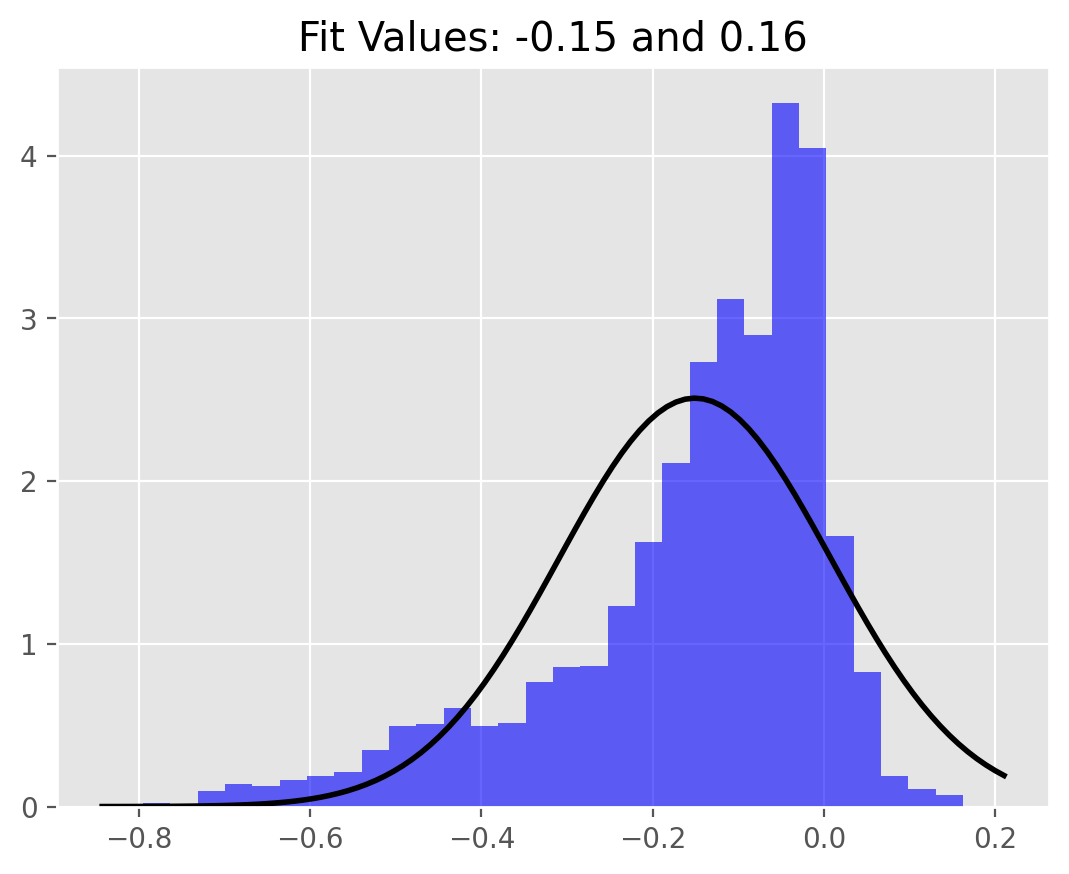

In [95]:
norm_hist(cell_dict["ACH-000068"]["AUCError"])

In [99]:
cell_dict["ACH-000923"]

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.7965,ACH-000923,Drug_1016,0.8865,0.090040
1,0.1923,ACH-000923,Drug_1030,0.2414,0.049080
2,0.6592,ACH-000923,Drug_1032,0.7175,0.058330
3,0.7702,ACH-000923,Drug_1035,0.7511,-0.019110
4,0.5482,ACH-000923,Drug_1068,0.5514,0.003195
...,...,...,...,...,...
70,0.6116,ACH-000923,Drug_781,0.7587,0.147100
71,0.5406,ACH-000923,Drug_865,0.5702,0.029630
72,0.0310,ACH-000923,Drug_984,0.6211,0.590100
73,0.8310,ACH-000923,Drug_987,0.9533,0.122300


## ACH-000923 --> High var: it is because low sample count

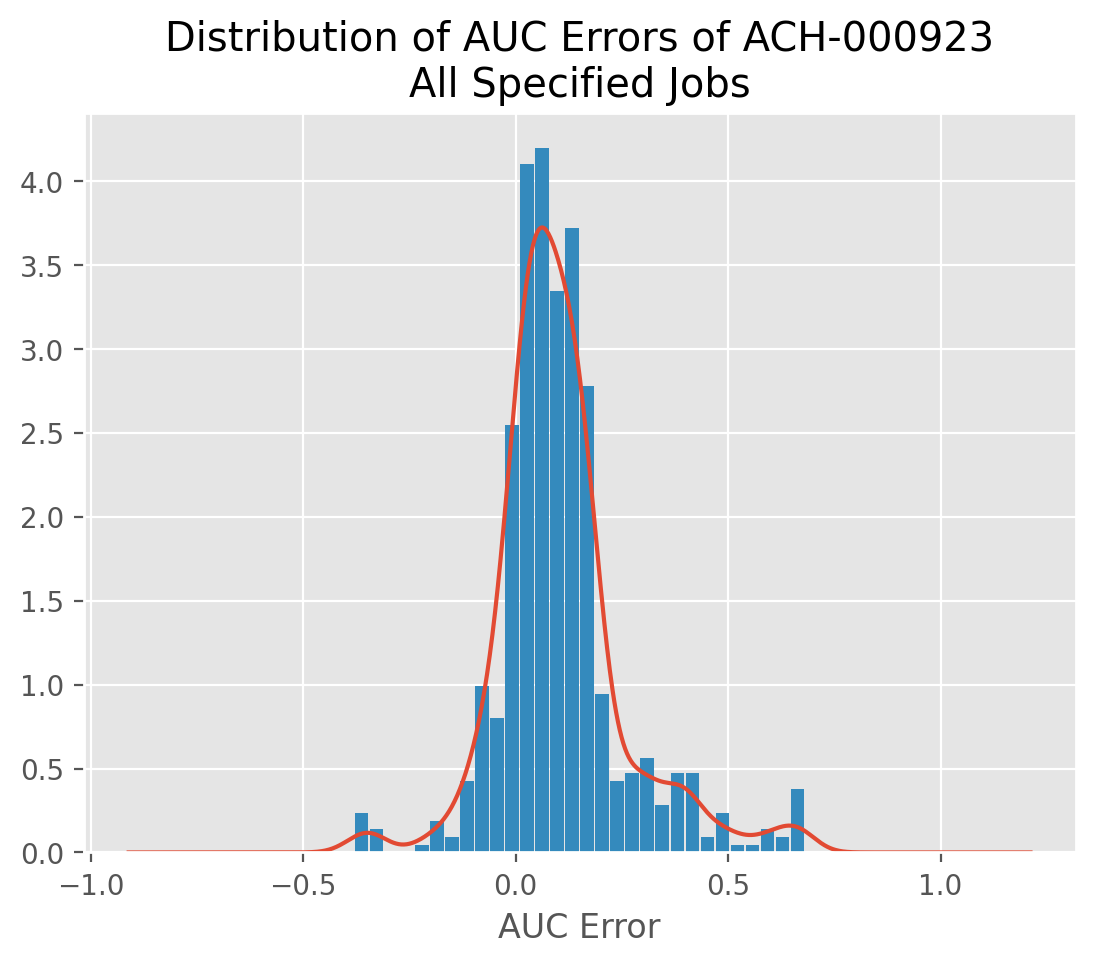

In [97]:
make_distrib_plot("ACH-000923", cell_dict)

TOTAL: 8-----((2.0, 4.0))


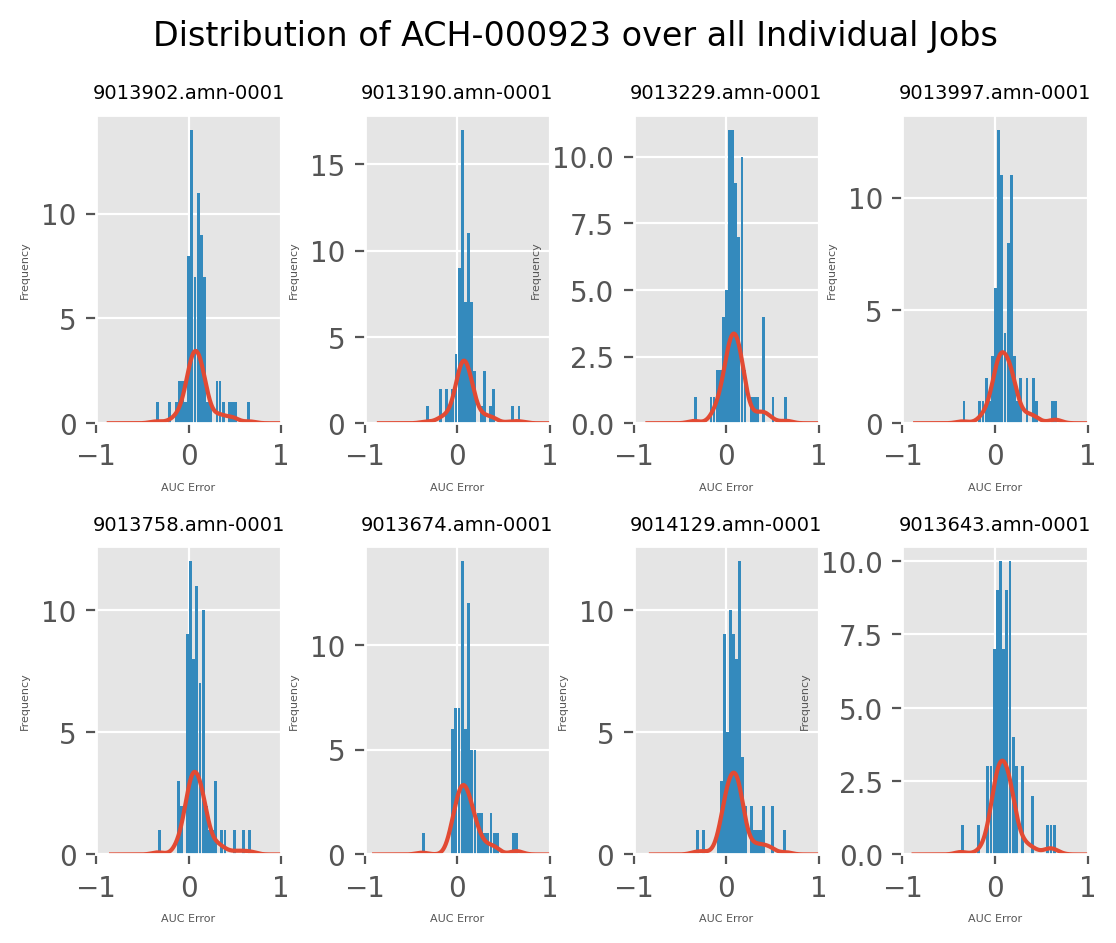

In [98]:
make_multiplot("ACH-000923", path=path, wanted_jobs=os.listdir(path))